# Numerical project
_Authors: Gaspard BLAISE, Shun Ye CHEN, Dimitri DE SAINT GUILHEM_

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("../data/first_database.pkl", "rb")as f:
    dataX,dataY=pickle.load(f)

In [69]:
# parameters
n = 1000
m = 30
a = 10
sigma = 0.5
nu = 1.0

In [70]:
sel = list(range(n))
ind = np.random.choice(sel,m,replace=False)
x_selected = dataX[ind] # ids_M
ind

array([432,  13, 227, 139, 926, 322, 990, 222, 887, 638, 684, 367, 375,
        46, 397, 840, 154, 494, 408, 362, 531, 438, 998, 932, 620, 653,
       723, 777, 648, 224])

In [72]:
sel_copy = np.arange(n)
np.random.shuffle(sel_copy)
agents = np.array_split(sel_copy, a)

In [73]:
from utils.kernel import kernel_matrix
Kmm = kernel_matrix(dataX, ind, ind)
Knm = kernel_matrix(dataX, sel, ind)

In [74]:
import networkx as nx
G = nx.cycle_graph(a)

In [75]:
from utils.graph_tools import laplacian_weight_matrix
W = laplacian_weight_matrix(G, 0.1)
print(W)
gamma = np.sort(np.linalg.eig(W)[0])[-2]
print(gamma)

[[0.8 0.1 0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.1 0.8 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.8 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.8 0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0.8]]
0.9618033988749893


In [76]:
step_count = int(1e5)

## Part I

### Primal methods

In [77]:
from utils.kernel import calc_smooth

step_size = 1/calc_smooth(Kmm, Knm)[0][0]
step_size = np.real(step_size)
step_size

7.41181446370706e-05

In [78]:
from algorithms.dgd import dgd
from utils.kernel import plot_optimality_gap
import matplotlib.pyplot as plt

xi_dgd = dgd(a, m, agents, Kmm, Knm, W, dataY, step_count, step_size=step_size)
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd, axis=1), label="alpha=%.4f" % step_size)

var_step_sizes = [lambda x:0.02/(x/100+1), lambda x:0.02/np.sqrt(x+100)]
names = [r"$\alpha_k=\frac{0.02}{0.01k+1}$", r"$\alpha_k=\frac{0.02}{\sqrt{k+100}}$"]

for i, vs in enumerate(var_step_sizes):
    xi = dgd(a, m, agents, Kmm, Knm, W, dataY, step_count, vs, constant_step_size=False)
    plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi, axis=1), label=names[i], alpha=0.5)

powers = [0.5, 0.7, 1]
starts = [0.1, 0.05, 0.02]

for p in powers:
    for st in starts:
        vs = lambda x: st/np.power(x+1, p)
        xi = dgd(a, m, agents, Kmm, Knm, W, dataY, step_count, vs, constant_step_size=False)
        plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi, axis=1), label=f"{st}/(x+1)^{p}", alpha=0.5)

plt.legend(loc="upper right")
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("DGD with decreasing step size (Laplacian weight matrix of a cycle graph)")
plt.show()

KeyboardInterrupt: 

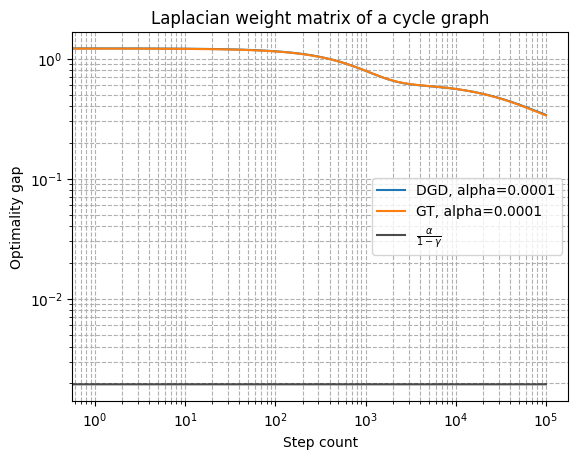

In [80]:
from algorithms.dgd import dgd
from algorithms.gradient_tracking import gt

from utils.kernel import plot_optimality_gap
import matplotlib.pyplot as plt

xi_dgd = dgd(a, m, agents, Kmm, Knm, W, dataY, step_count, step_size=step_size)
xi_gt = gt(a, m, agents, Kmm, Knm, W, dataY, step_count, step_size=step_size) #0.01

# var_step_size = lambda x: 0.02/(x/100 + 1)
# xi_dgd_decreasing = dgd(a, m, agents, Kmm, Knm, W, dataY, step_count, var_step_size, constant_step_size=False)

plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd, axis=1), label="DGD, alpha=%.4f" % step_size)
# plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd_decreasing, axis=1), label=r"DGD, $\alpha_k=\frac{0.02}{0.01k+1}$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_gt, axis=1), label="GT, alpha=%.4f" % step_size)

plt.plot([step_size/(1-gamma)]*(step_count+1), alpha=0.7, color="black", label=r"$\frac{\alpha}{1-\gamma}$")

plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Laplacian weight matrix of a cycle graph")
plt.show()

In [ ]:
xi_dgd

Let's try with another weight matrix (we need to adapt the step size also):

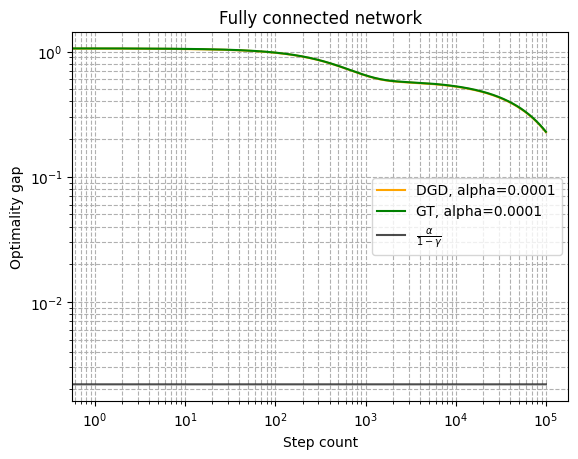

In [66]:
from utils.graph_tools import metropolis_weight_matrix

W2 = np.ones((a,a))/a
xi_dgd2 = dgd(a, m, agents, Kmm, Knm, W2, dataY, step_count, step_size=step_size)
xi_gt2 = gt(a, m, agents, Kmm, Knm, W2, dataY, step_count, step_size=step_size)

plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd2, axis=1), label="DGD, alpha=%.4f" % step_size, color="orange")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_gt2, axis=1), label="GT, alpha=%.4f" % step_size, color="green")

plt.plot([step_size/(1-gamma)]*(step_count+1), alpha=0.7, color="black", label=r"$\frac{\alpha}{1-\gamma}$")

plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Fully connected network")
plt.show()

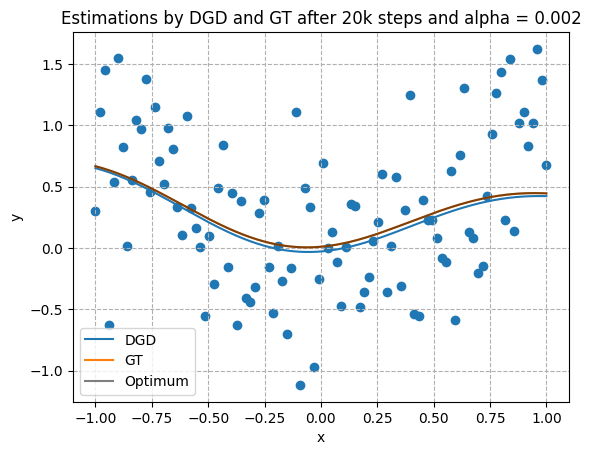

In [35]:
from utils.kernel import calc_f, calc_alpha_opt

plt.scatter(dataX[:n], dataY[:n])

nt = 250
x_linspace = np.linspace(-1, 1, nt)

pred_dgd = [calc_f(dataX, ind, v, xi_dgd[step_count, 0, :]) for v in x_linspace]
plt.plot(x_linspace, pred_dgd, label="DGD")

pred_gt = [calc_f(dataX, ind, v, xi_gt[step_count, 0, :]) for v in x_linspace]
plt.plot(x_linspace, pred_gt, label="GT")

optimal = [calc_f(dataX, ind, v, calc_alpha_opt(Kmm, Knm, dataY[:n])) for v in x_linspace]
plt.plot(x_linspace, optimal, label="Optimum", color="black", alpha=0.5)

plt.grid(True, which="both", ls="--")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Estimations by DGD and GT after 20k steps and alpha = %.3f" % step_size)
plt.legend()
plt.show()

### Dual methods

Let's first find the best values for the learning rates / step sizes:

d:\cours\ENSTA\P4\coop\cooperative-optimization\src\utils\kernel.py:59: RuntimeWarning: overflow encountered in square
  opt_gap = [np.sqrt(np.sum((alpha_opt - alphas_over_time[i,:])**2))
d:\cours\ENSTA\P4\coop\cooperative-optimization\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\cours\ENSTA\P4\coop\cooperative-optimization\src\algorithms\dual_decomp.py:15: RuntimeWarning: invalid value encountered in subtract
  b -= lambda_ij[step, agentId, j, :] * (2*(agentId > j) - 1)
d:\cours\ENSTA\P4\coop\cooperative-optimization\.venv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


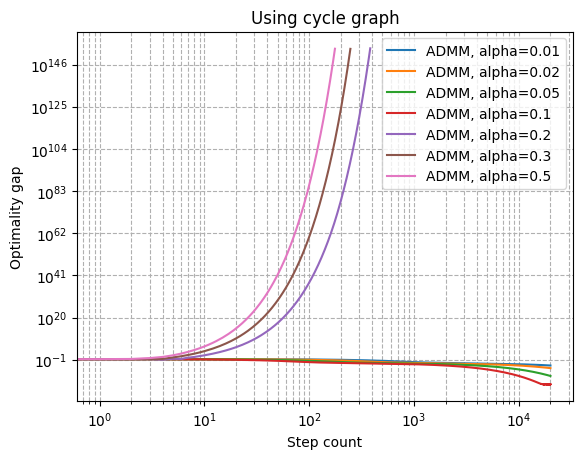

In [49]:
from algorithms.dual_decomp import dual_decomp

step_counts = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]

for sc in step_counts:
    xi_dd = dual_decomp(a, m, agents, Kmm, Knm, G, dataY, step_count, sc)
    plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dd, axis=1), label=f"ADMM, alpha={sc}")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Using cycle graph")
plt.show()

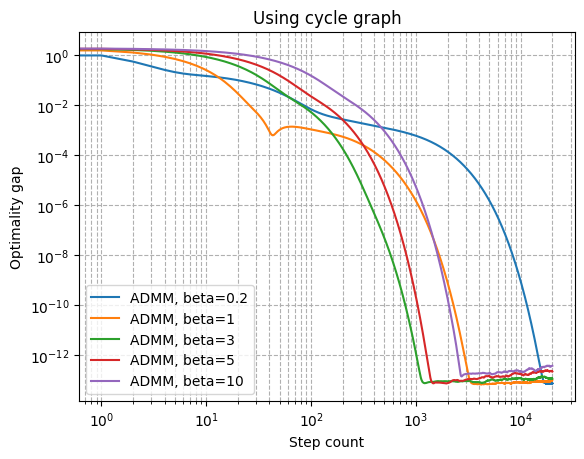

In [50]:
from algorithms.admm import admm

betas = [0.2, 1, 3, 5, 10]

for b in betas:
    xi_admm = admm(a, m, agents, Kmm, Knm, G, dataY, step_count, beta=b)
    plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_admm, axis=1), label=f"ADMM, beta={b}")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Using cycle graph")
plt.show()

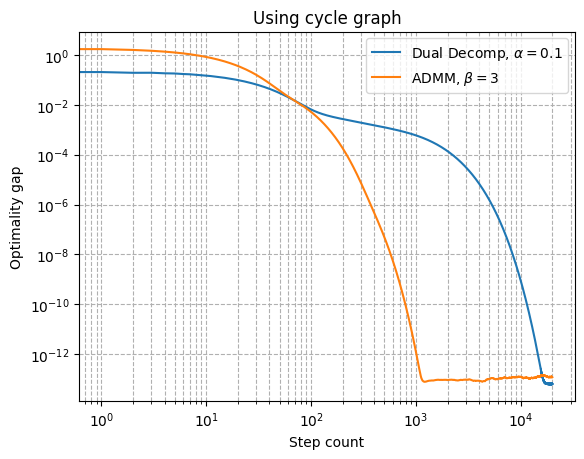

In [51]:
from algorithms.dual_decomp import dual_decomp
from algorithms.admm import admm

xi_dd = dual_decomp(a, m, agents, Kmm, Knm, G, dataY, step_count, step_size=0.1)
xi_admm = admm(a, m, agents, Kmm, Knm, G, dataY, step_count, beta=3)

plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dd, axis=1), label=r"Dual Decomp, $\alpha=0.1$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_admm, axis=1), label=r"ADMM, $\beta=3$")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Using cycle graph")
plt.show()

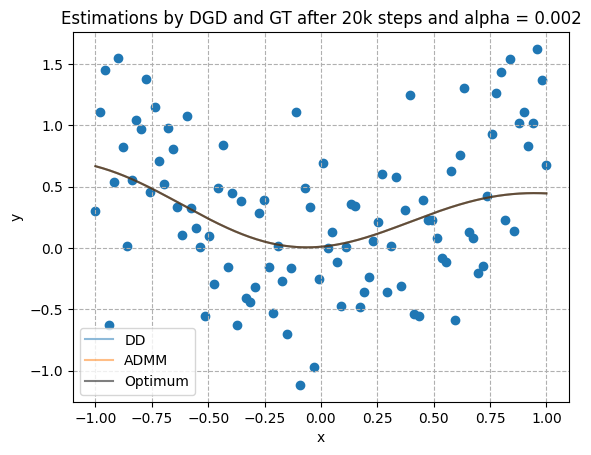

In [53]:
plt.scatter(dataX[:n], dataY[:n])

nt = 250
x_linspace = np.linspace(-1, 1, nt)

pred_dd = [calc_f(dataX, ind, v, xi_dd[step_count, 0, :]) for v in x_linspace]
plt.plot(x_linspace, pred_dd, label="DD", alpha=0.5)

pred_admm = [calc_f(dataX, ind, v, xi_admm[step_count, 0, :]) for v in x_linspace]
plt.plot(x_linspace, pred_admm, label="ADMM", alpha=0.5)

optimal = [calc_f(dataX, ind, v, calc_alpha_opt(Kmm, Knm, dataY[:n])) for v in x_linspace]
plt.plot(x_linspace, optimal, label="Optimum", color="black", alpha=0.5)

plt.grid(True, which="both", ls="--")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Estimations by DGD and GT after 20k steps and alpha = %.3f" % step_size)
plt.legend()
plt.show()

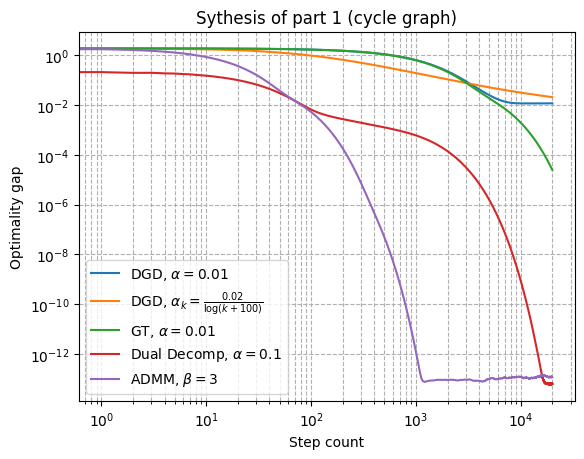

In [52]:
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd, axis=1), label=r"DGD, $\alpha=0.01$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dgd_decreasing, axis=1), label=r"DGD, $\alpha_k=\frac{0.02}{\log(k+100)}$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_gt, axis=1), label=r"GT, $\alpha=0.01$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_dd, axis=1), label=r"Dual Decomp, $\alpha=0.1$")
plot_optimality_gap(Kmm, Knm, dataY[:n], np.mean(xi_admm, axis=1), label=r"ADMM, $\beta=3$")

plt.legend()
plt.grid(True, which="both", ls="--")
plt.xlabel("Step count")
plt.ylabel("Optimality gap")
plt.title("Sythesis of part 1 (cycle graph)")
plt.show()